<a href="https://colab.research.google.com/github/SomaGergo233650/RL/blob/main/best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install transformers datasets scikit-learn datasets --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, accuracy_score
import torch


In [ ]:


# Load your balanced dataset
df = pd.read_csv("final_balanced_emotions.csv")

# Define target emotions
target_emotions = ['happiness', 'sadness', 'anger', 'surprise', 'fear', 'disgust', 'neutral']

# Filter only valid emotions
df = df[df['Emotion'].isin(target_emotions)].reset_index(drop=True)

# Clean text column
df = df.dropna(subset=['Text'])
df['Text'] = df['Text'].astype(str)


In [ ]:
print(df['Emotion'].value_counts())


Emotion
anger        1490
disgust      1490
fear         1490
happiness    1490
neutral      1490
sadness      1490
surprise     1490
Name: count, dtype: int64


In [ ]:
# Map emotion labels to integers
label2id = {label: idx for idx, label in enumerate(target_emotions)}
id2label = {v: k for k, v in label2id.items()}

df['label_id'] = df['Emotion'].map(label2id)

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=42)

# Rename for compatibility with HuggingFace
train_df = train_df.rename(columns={'label_id': 'labels'})
val_df = val_df.rename(columns={'label_id': 'labels'})

# Create HuggingFace DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df[['Text', 'labels']]),
    'validation': Dataset.from_pandas(val_df[['Text', 'labels']])
})


In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['Text'], truncation=True, padding=True)

# Apply tokenizer to dataset
dataset = dataset.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8344 [00:00<?, ? examples/s]

Map:   0%|          | 0/2086 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(target_emotions),
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,  # can increase a bit if no overfitting
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    lr_scheduler_type="linear",
    warmup_steps=500
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
    }



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

from transformers import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Custom class weights: upweight 'surprise' and 'disgust'
        weights = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0]).to(logits.device)
        loss_fct = CrossEntropyLoss(weight=weights)

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


<ipython-input-9-eeae80ea8811>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 233650 (233650-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Recall,Precision
1,1.503900,0.853477,0.732982,0.731658,0.732982,0.732313
2,0.661500,0.745193,0.771812,0.770207,0.771812,0.781155
3,0.382900,0.810028,0.773250,0.772492,0.773250,0.779284
4,0.236100,0.834454,0.789070,0.789088,0.789070,0.791203
5,0.138900,0.997666,0.786194,0.785055,0.786194,0.786804
6,0.087900,1.015659,0.790029,0.788958,0.790029,0.789882


TrainOutput(global_step=3132, training_loss=0.484830675758469, metrics={'train_runtime': 1831.2653, 'train_samples_per_second': 27.338, 'train_steps_per_second': 1.71, 'total_flos': 3557725400359200.0, 'train_loss': 0.484830675758469, 'epoch': 6.0})

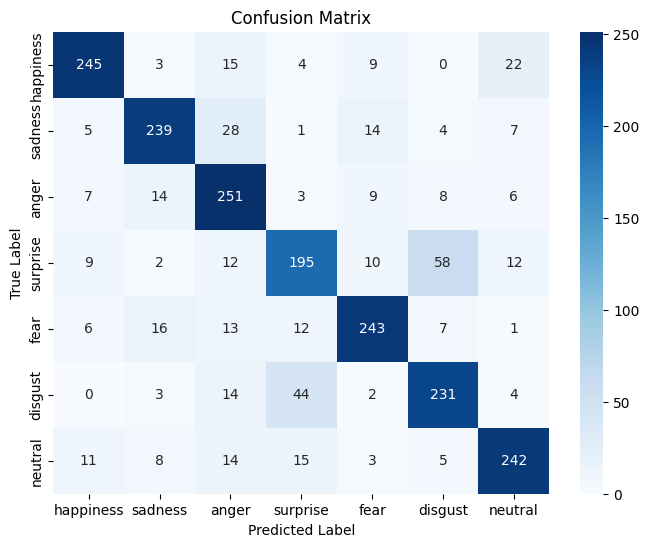

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on validation set
predictions = trainer.predict(dataset["validation"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_emotions, yticklabels=target_emotions)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Predict on the validation set
predictions = trainer.predict(dataset["validation"])

# Get predicted and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


In [ ]:
# F1 Score (macro, micro, and weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("F1 Macro:", round(f1_macro, 4))
print("F1 Micro:", round(f1_micro, 4))
print("F1 Weighted:", round(f1_weighted, 4))


F1 Macro: 0.7891
F1 Micro: 0.7891
F1 Weighted: 0.7891


In [ ]:
# Save model and tokenizer locally in Colab
model.save_pretrained("emotion-bert-model")
tokenizer.save_pretrained("emotion-bert-model")


('emotion-bert-model/tokenizer_config.json',
 'emotion-bert-model/special_tokens_map.json',
 'emotion-bert-model/vocab.txt',
 'emotion-bert-model/added_tokens.json',
 'emotion-bert-model/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Zip the model folder
shutil.make_archive("emotion-bert-model", 'zip', "emotion-bert-model")

# Download it
files.download("emotion-bert-model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>